In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from preparation.data import Data
import h5py
import os
import shutil

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, :]
        plt.imshow(img)
    plt.show()

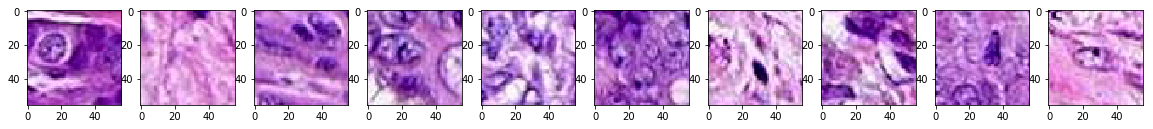

In [4]:
data = Data(dataset='nki', marker='he', patch_h=56, patch_w=56, n_channels=3, batch_size=10)
images, label = data.training.next_batch(10)

plot_images(plt_num=10, images=images, dim=20)

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [6]:
def discriminator(images, reuse, alpha, use_bn):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # Input Shape = (None, 56, 56, 3)
        
        # Conv.
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        net = leakyReLU(net, alpha)
        # Shape = (None, 28, 28, 64)
        
        # Conv.
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        if use_bn: net = tf.layers.batch_normalization(inputs=net, training=True)
        net = leakyReLU(net, alpha)
        # Shape = (None, 14, 14, 128)
        
        # Conv.
        net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        if use_bn: net = tf.layers.batch_normalization(inputs=net, training=True)
        net = leakyReLU(net, alpha)
        # Shape = (None, 7, 7, 256)
        
        # Conv.
        net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        if use_bn: net = tf.layers.batch_normalization(inputs=net, training=True)
        net = leakyReLU(net, alpha)
        # Shape = (None, 7, 7, 256)

        # Flatten.
        net = tf.layers.flatten(inputs=net)
        # Shape = (None, 7*7*256)

        # Dense.
        net = tf.layers.dense(inputs=net, units=1024, activation=None)
        if use_bn: net = tf.layers.batch_normalization(inputs=net, training=True)
        net = leakyReLU(net, alpha)
        # Shape = (None, 1024)
        
        # Dense
        logits = tf.layers.dense(inputs=net, units=1, activation=None)
        # Shape = (None, 1)
        output = tf.nn.sigmoid(x=logits)
        
        return output, logits

In [7]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        # Doesn't work ReLU, tried.
        
        # Input Shape = (None, 100)
        
        # Dense.
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 1024)
        
        # Dense.
        net = tf.layers.dense(net, 256*7*7, activation=None)
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 256*7*7)
        
        # Reshape
        net = tf.reshape(tensor=net, shape=(-1, 7, 7, 256), name='reshape')
        # Shape = (None, 7, 7, 256)
        
        # Conv.
        net = tf.layers.conv2d_transpose(inputs=net, filters=256, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 14, 14, 256)
        
        # Conv.
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 14, 14, 128)
        
        # Conv.
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 28, 28, 128)
        
        # Conv.
        net = tf.layers.conv2d_transpose(inputs=net, filters=64, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 14, 14, 128)
        
        # Conv.
        net = tf.layers.conv2d_transpose(inputs=net, filters=64, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.batch_normalization(inputs=net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape = (None, 28, 28, 128)
        
        logits = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='logits')
        # Shape = (None, 56, 56, 3)
        output = tf.nn.sigmoid(x=logits)
        
        return output

In [8]:
def show_generated(session, output_fake, n_images, z_input):
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    plot_images(plt_num=n_images, images=gen_samples, dim=20)    
    return gen_samples, sample_z

In [9]:
def save_loss(losses, data_out_path, dim):    
    mpl.rcParams["figure.figsize"] = dim, dim
    plt.rcParams.update({'font.size': 22})
    losses = np.array(losses)
    plt.plot(losses[:, 0], label='Discriminator', alpha=0.5)
    plt.plot(losses[:, 1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.savefig('%s/training_loss.png' % data_out_path)

In [10]:
def setup_output(show_epochs, epochs, data, n_images, image_height, image_width, image_channels, z_dim, data_out_path):
    checkpoints_path = os.path.join(data_out_path, 'checkpoints')
    checkpoints = os.path.join(checkpoints_path, 'DCGAN.ckt')
    gen_images_path = os.path.join(data_out_path, 'images')
    gen_images = os.path.join(gen_images_path, 'gen_images.h5')
    latent_images = os.path.join(gen_images_path, 'latent_images.h5')
    if os.path.isdir(checkpoints_path):
         shutil.rmtree(checkpoints_path)
    if os.path.isdir(gen_images_path):
         shutil.rmtree(gen_images_path)
    os.makedirs(checkpoints_path)
    os.makedirs(gen_images_path)

    size_img = (epochs*data.training.iterations)//show_epochs
    img_db_shape = (size_img, n_images, image_height, image_width, image_channels)
    latent_db_shape = (size_img, n_images, z_dim)
    hdf5_gen = h5py.File(gen_images, mode='w')
    hdf5_latent = h5py.File(latent_images, mode='w')
    img_storage = hdf5_gen.create_dataset(name='generated_img', shape=img_db_shape, dtype=np.float32)
    latent_storage = hdf5_latent.create_dataset(name='generated_img', shape=latent_db_shape, dtype=np.float32)
    return img_storage, latent_storage, checkpoints

In [11]:
def loss(real_images, z_input, out_channel_dim, alpha, use_bn):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha, use_bn=use_bn) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha, use_bn=use_bn)
    
    # Discriminator loss.
    loss_dis_fake = tf.reduce_mean(tf.square(output_fake))
    loss_dis_real = tf.reduce_mean(tf.square(output_real-1.0))
    loss_dis = 0.5*(loss_dis_fake + loss_dis_real)

    # Generator loss.
    loss_gen = 0.5*tf.reduce_mean(tf.square(output_fake-1.0))
    
    return loss_dis, loss_gen

In [12]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [13]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, data, alpha, image_width, image_height, image_channels, data_out_path, use_bn):
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha, use_bn=use_bn)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    global losses 
    global samples 
    
    run_epochs = 0    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
        
    losses = list()
    samples = list()

    saver = tf.train.Saver()
    
    img_storage, latent_storage, checkpoints = setup_output(show_epochs, epochs, data, n_images, image_height, image_width, image_channels, z_dim, data_out_path)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(1, epochs+1):
            for batch_images, batch_labels in data.training:
                # Inputs.
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))               
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}

                # Run gradient.
                session.run(train_discriminator, feed_dict=feed_dict)
                session.run(train_generator, feed_dict=feed_dict)

                # Print losses and Generate samples.
                if run_epochs % print_epochs == 0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 4), np.round(epoch_loss_dis, 4)))
                if run_epochs % show_epochs == 0:
                    gen_samples, sample_z = show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input)
                    img_storage[run_epochs//show_epochs] = gen_samples
                    latent_storage[run_epochs//show_epochs] = sample_z
                    saver.save(sess=session, save_path=checkpoints, global_step=run_epochs)
                run_epochs += 1
            data.training.reset()

Epochs 1/3: Generator Loss: 0.2403. Discriminator Loss: 0.3919


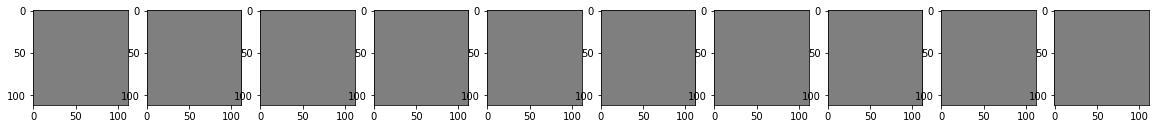

Epochs 1/3: Generator Loss: 0.2254. Discriminator Loss: 0.3674
Epochs 1/3: Generator Loss: 0.2359. Discriminator Loss: 0.3487
Epochs 1/3: Generator Loss: 0.2436. Discriminator Loss: 0.3446
Epochs 1/3: Generator Loss: 0.2547. Discriminator Loss: 0.3291
Epochs 1/3: Generator Loss: 0.2039. Discriminator Loss: 0.3866
Epochs 1/3: Generator Loss: 0.2316. Discriminator Loss: 0.3293
Epochs 1/3: Generator Loss: 0.2554. Discriminator Loss: 0.3233
Epochs 1/3: Generator Loss: 0.2277. Discriminator Loss: 0.3106
Epochs 1/3: Generator Loss: 0.2059. Discriminator Loss: 0.3116
Epochs 1/3: Generator Loss: 0.235. Discriminator Loss: 0.2714


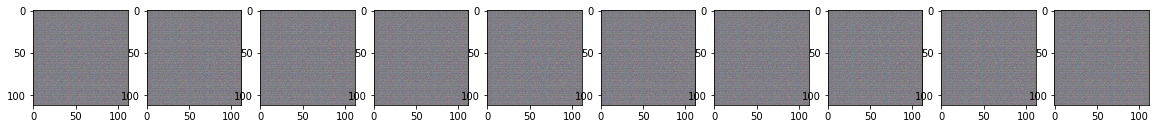

Epochs 1/3: Generator Loss: 0.2207. Discriminator Loss: 0.2851
Epochs 1/3: Generator Loss: 0.2613. Discriminator Loss: 0.2317
Epochs 1/3: Generator Loss: 0.2141. Discriminator Loss: 0.2611
Epochs 1/3: Generator Loss: 0.2221. Discriminator Loss: 0.2288
Epochs 1/3: Generator Loss: 0.1834. Discriminator Loss: 0.2484
Epochs 1/3: Generator Loss: 0.0642. Discriminator Loss: 0.2811
Epochs 1/3: Generator Loss: 0.1951. Discriminator Loss: 0.1997
Epochs 1/3: Generator Loss: 0.1767. Discriminator Loss: 0.2447
Epochs 1/3: Generator Loss: 0.0972. Discriminator Loss: 0.2613
Epochs 1/3: Generator Loss: 0.1311. Discriminator Loss: 0.2498


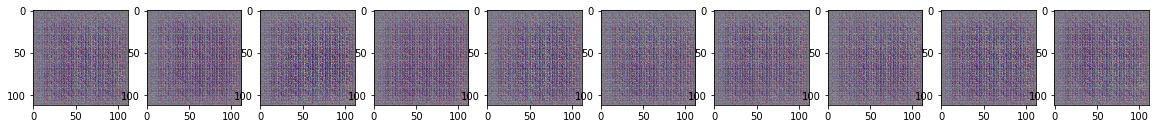

Epochs 1/3: Generator Loss: 0.1035. Discriminator Loss: 0.273
Epochs 1/3: Generator Loss: 0.1107. Discriminator Loss: 0.2453
Epochs 1/3: Generator Loss: 0.116. Discriminator Loss: 0.2461
Epochs 1/3: Generator Loss: 0.1338. Discriminator Loss: 0.2325
Epochs 1/3: Generator Loss: 0.1272. Discriminator Loss: 0.2432
Epochs 1/3: Generator Loss: 0.1252. Discriminator Loss: 0.2577
Epochs 1/3: Generator Loss: 0.1307. Discriminator Loss: 0.2514
Epochs 1/3: Generator Loss: 0.1358. Discriminator Loss: 0.2357
Epochs 1/3: Generator Loss: 0.1379. Discriminator Loss: 0.2204
Epochs 1/3: Generator Loss: 0.142. Discriminator Loss: 0.2347


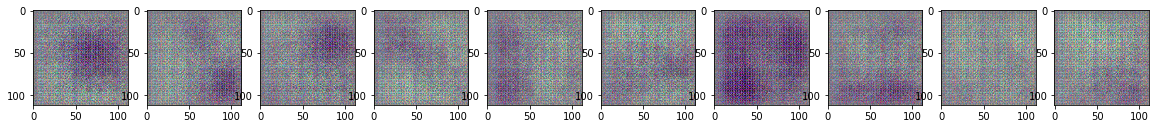

Epochs 1/3: Generator Loss: 0.1248. Discriminator Loss: 0.236
Epochs 1/3: Generator Loss: 0.1381. Discriminator Loss: 0.2297
Epochs 1/3: Generator Loss: 0.122. Discriminator Loss: 0.2407
Epochs 1/3: Generator Loss: 0.1322. Discriminator Loss: 0.2371
Epochs 1/3: Generator Loss: 0.1407. Discriminator Loss: 0.2294
Epochs 1/3: Generator Loss: 0.1269. Discriminator Loss: 0.2342
Epochs 1/3: Generator Loss: 0.1386. Discriminator Loss: 0.2377
Epochs 1/3: Generator Loss: 0.128. Discriminator Loss: 0.2329
Epochs 1/3: Generator Loss: 0.136. Discriminator Loss: 0.2423
Epochs 1/3: Generator Loss: 0.1245. Discriminator Loss: 0.251


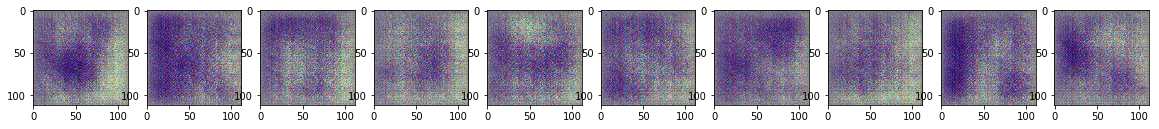

Epochs 1/3: Generator Loss: 0.1719. Discriminator Loss: 0.1836
Epochs 1/3: Generator Loss: 0.1673. Discriminator Loss: 0.2019
Epochs 1/3: Generator Loss: 0.1749. Discriminator Loss: 0.2437
Epochs 1/3: Generator Loss: 0.1564. Discriminator Loss: 0.2143
Epochs 1/3: Generator Loss: 0.1544. Discriminator Loss: 0.2458
Epochs 1/3: Generator Loss: 0.1404. Discriminator Loss: 0.2934
Epochs 1/3: Generator Loss: 0.204. Discriminator Loss: 0.1745
Epochs 1/3: Generator Loss: 0.2421. Discriminator Loss: 0.2035
Epochs 1/3: Generator Loss: 0.1868. Discriminator Loss: 0.2867
Epochs 1/3: Generator Loss: 0.194. Discriminator Loss: 0.2199


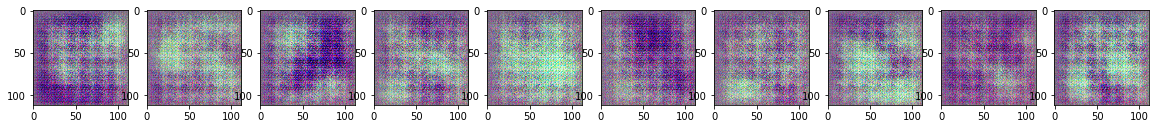

Epochs 1/3: Generator Loss: 0.2145. Discriminator Loss: 0.2149
Epochs 1/3: Generator Loss: 0.2568. Discriminator Loss: 0.1596
Epochs 1/3: Generator Loss: 0.1928. Discriminator Loss: 0.2339
Epochs 1/3: Generator Loss: 0.2524. Discriminator Loss: 0.3304
Epochs 1/3: Generator Loss: 0.2838. Discriminator Loss: 0.2453
Epochs 1/3: Generator Loss: 0.1853. Discriminator Loss: 0.2305
Epochs 1/3: Generator Loss: 0.3046. Discriminator Loss: 0.157
Epochs 1/3: Generator Loss: 0.3423. Discriminator Loss: 0.1023
Epochs 1/3: Generator Loss: 0.2493. Discriminator Loss: 0.1913
Epochs 1/3: Generator Loss: 0.1873. Discriminator Loss: 0.189


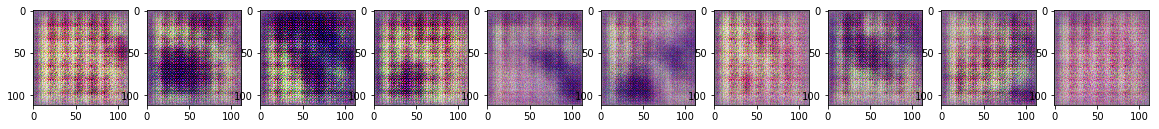

Epochs 1/3: Generator Loss: 0.3026. Discriminator Loss: 0.0871


KeyboardInterrupt: 

In [14]:
main_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/Cancer_TMA_Generative/data model output/LSGAN/'

# Dataset information.
image_width = 112
image_height = 112
image_channels = 3
dataset='nki'
marker='he'
name_run = 'h%s_w%s_n%s' % (image_height, image_width, image_channels)
data_out_path = '%s/%s' % (main_path, name_run)


# Hyperparameters.
epochs = 4
batch_size = 32
z_dim = 100
learning_rate = 5e-5
beta1 = 0.5
alpha = 0.2
use_bn = True

global losses 
global samples
data = Data(dataset, marker, image_height, image_width, image_channels, batch_size)

with tf.Graph().as_default():
   train(epochs, batch_size, z_dim, learning_rate, beta1, data, alpha, image_width, image_height, image_channels, data_out_path, use_bn)

In [ ]:
save_loss(losses, data_out_path, dim=20)